# Habitability Unconsrtained Index (HUI) workbook

##### Disclaimer:
This script requires specific naming of columns within the data. If you would like to run **HUI** with your own data, please ensure column names and units adhere to the following format:
- **COLUMN NAME  //       *COLUMN UNIT***
- **planet** // *name of planet* 
- **planet_mass_mjup** // *mass of planet in Jupiter masses (M_Jup)*
- **planet_radius_rjup** // *radius of planet in Jupiter radii (R_Jup)*
- **planet_temperature_K** // *either recorded or calculated temperature of planet in Kelvin (K)*
- **star_name** // *name of relevant star*
- **star_distance_AU** // *distance from star to planet in astronomical units (AU)*
- **star_mass_msun** // *mass of star in Sun masses (M_Sun)*
- **star_radius_rsun** // *radius of star in Sun radii (R_Sun)*
- **star_age_Gy** // *star age in billions of years (Gy)*
- **star_teff_K** // *effective temperature of a star (T_eff) in Kelvin (K)*


## Section 1: Preparation
This section configures the environment, imports python modules, defines helper fuctions and calculates additinal data required in preparation for HUI computation.

In [1]:
# IMPORT PYTHON PACKAGES
import numpy as np
import pandas as pd
import math 
from math import pi
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.special import betainc
import seaborn as sns

# SET-UP PANDAS DISPLAY OPTIONs
pd.set_option('display.max_columns', None)  # None means no limit
pd.set_option('display.max_rows', None) 

In [2]:
# IMPORT DATA
data_with_NA = pd.read_csv('../Data/full_data.csv')
data_without_NA = pd.read_csv('../Data/data_without_NA.csv')
data = data_without_NA

# ADD COLUMN FOR MISSING DATA IDENTIFICATION
def add_missing_data_indicator(df):
    df['has_missing_data'] = df.isnull().any(axis=1)
    return df

data = add_missing_data_indicator(data)

In [3]:
# DEFINE HELPER FUNCTIONS
def map_value(value, from_min, from_max, to_min, to_max):
    """
    Maps a value from one range to another.

    Parameters:
    value (float): The value to be mapped.
    from_min (float): The minimum of the original range.
    from_max (float): The maximum of the original range.
    to_min (float): The minimum of the target range.
    to_max (float): The maximum of the target range.

    Returns:
    float: The value mapped to the target range.
    """
    # Calculate the proportion of the value within the original range
    proportion = (value - from_min) / (from_max - from_min)
    
    # Calculate the mapped value in the target range
    mapped_value = to_min + proportion * (to_max - to_min)
    
    return mapped_value

def index_from_min_ideal_max(value, ideal, min_anti_ideal, max_anti_ideal, LB, UB, extrema = 0.1):
    """
    Derives an index value from 0-1 for a quantity where both min and max anti-ideal values are known.

    Parameters:
    value (float): The value to be mapped.
    mid_ideal (float): The ideal value for given input.
    min_nonideal (float): The min non-ideal value for given input.
    max_anti_ideal (float): The max non-ideal value for given input.
    LB (float): The lower boundary representing the theoretical acceptable minimum for given input.
    UB (float): The upper boundary representing the theoretical acceptable maximum for given input.
    extrema (float): The maximum index value that can be scored if the input falls out of min non-ideal to max non-ideal range.

    Returns:
    float: The index value obtained from the given input.
    """

    # Guard against NaN
    if (math.isnan(value)):
        return extrema 

    # Case 0: value is ideal -> return 1
    if value == ideal:
        return 1
    
    # Case 1: value is between ideal and max nonideal -> map value from -1 to -lowest score
    if ideal < value < max_anti_ideal:
        index = 0 - map_value(value, ideal, max_anti_ideal, -1, -extrema)
        return index
    
    # Case 2: value is between min nonideal and ideal -> map value value from 0.1 to 1
    if min_anti_ideal < value < ideal:
        index = map_value(value, min_anti_ideal, ideal, extrema, 1)
        return index
    
    # Case 3: value is between max nonideal and UB -> by definition the tempearture is non-ideal and would have scored 0.1
    #         however as it is past the max value map it to the range 0 -> 0.1 and subtract from 0.1 to get the final result
    if max_anti_ideal < value < UB:
        decrement = map_value(value, max_anti_ideal, UB, 0, extrema)
        index = extrema - decrement
        return index
    
    # Case 4: value is between LB and min nonideal -> by definition the value is non-ideal and woudld have scored 0.1
    #         however as it is less than min nonideal map it to the range -0.1 -> 0 and add it to 0.1 to get the final result
    if LB < value < min_anti_ideal:
        decrement = map_value(value, LB, min_anti_ideal, -extrema, 0)
        index = extrema + decrement
        return index
    
    return 666

def index_from_min_ideal(value, ideal, min_anti_ideal, LB, extrema = 0.1):
    """
    Derives an index value from 0-1 for a quantity where only the min non-ideal value is known.

    Parameters:
    value (float): The value to be mapped.
    mid_ideal (float): The ideal value for given input.
    min_nonideal (float): The min non-ideal value for given input.
    LB (float): The lower boundary representing the theoretical acceptable minimum for given input.
    extrema (float): The maximum index value that can be scored if the input falls out of min non-ideal to max non-ideal range.

    Returns:
    float: The index value obtained from the given input. 
    """

    # Guard against NaN
    if (math.isnan(value)):
        return extrema 

    # Case 0: value is ideal -> return 1
    if value == ideal:
        return 1
    
    # Case 1: value is between min nonideal and ideal -> map value value from 0.1 to 1
    if min_anti_ideal < value < ideal:
        index = map_value(value, min_anti_ideal, ideal, extrema, 1)
        return index
    
    # Case 2: value is between LB and min nonideal -> by definition the value is non-ideal and woudld have scored 0.1
    #         however as it is less than min nonideal map it to the range -0.1 -> 0 and add it to 0.1 to get the final result
    if LB < value < min_anti_ideal:
        decrement = map_value(value, LB, min_anti_ideal, -extrema, 0)
        index = extrema + decrement
        return index
    
    return 666

def index_from_ideal_max(value, ideal, max_anti_ideal, UB, extrema = 0.1):
    """
    Derives an index value from 0-1 for a quantity where only the max non-ideal value is known.

    Parameters:
    value (float): The value to be mapped.
    mid_ideal (float): The ideal value for given input.
    max_anti_ideal (float): The max non-ideal value for given input.
    UB (float): The upper boundary representing the theoretical acceptable maximum for given input.
    extrema (float): The maximum index value that can be scored if the input falls out of min non-ideal to max non-ideal range.

    Returns:
    float: The index value obtained from the given input. 
    """

    # Guard against NaN
    if (math.isnan(value)):
        return extrema 

    # Case 0: value is ideal -> return 1
    if value == ideal:
        return 1
    
    # Case 1: value is between ideal and max nonideal -> map value from -1 to -lowest score
    if ideal < value < max_anti_ideal:
        index = 0 - map_value(value, ideal, max_anti_ideal, -1, -extrema)
        return index
    
    # Case 2: value is between max nonideal and UB -> by definition the tempearture is non-ideal and would have scored 0.1
    #         however as it is past the max value map it to the range 0 -> 0.1 and subtract from 0.1 to get the final result
    if max_anti_ideal < value < UB:
        decrement = map_value(value, max_anti_ideal, UB, 0, extrema)
        index = extrema - decrement
        return index
    
    return 666

In [4]:
# DATA CONVERSION
def mjup_to_mearth(planet_mass_mjup):
    mass_mearth = planet_mass_mjup * 317.8 

    return mass_mearth

data['planet_mass_mearth'] = data.apply(lambda row: mjup_to_mearth(row['planet_mass_mjup']), axis = 1)

def rjup_to_rearth(planet_radius_rjup):
    radius_rearth = planet_radius_rjup * 11.2

    return radius_rearth

data['planet_radius_rearth'] = data.apply(lambda row: rjup_to_rearth(row['planet_radius_rjup']), axis = 1)

data['planet_mass_kg'] = data['planet_mass_mearth'] * 5.9722e24
data['planet_radius_m'] = data['planet_radius_rearth'] * (6378.137 * 1000)

## Section 2: Sub-Index Calculation

### Subsection 2.1: Habitability Zone Sub-Index

In [5]:
# CALCULATION OF NECESSARY PARAMETERS

# Luminosity
def mass_to_luminosity(star_mass_msun):
    return star_mass_msun  ** 3.6

data['Luminosity_Lsun'] = data['star_mass_msun'].apply(mass_to_luminosity) 

# Inner Flux 
def s_inner(Teff_K):
    flux_inner = 1.296 - (2.139e-4 * Teff_K) + 4.19e-8 * (Teff_K**2)

    return flux_inner

data['Flux_inner_HZ_boundary'] = data['star_teff_K'].apply(s_inner) 

# Outer Flux
def s_outer(Teff):
    flux_outer = 0.234 - (1.319e-5 * Teff) + 6.19e-10 * (Teff**2)

    return flux_outer

data['Flux_outer_HZ_boundary'] = data['star_teff_K'].apply(s_outer) 

# Inner HZ Boundary
def r_inner(Luminosity_Lsun, Flux_inner_HZ_boundary):
    r_inner = np.sqrt(Luminosity_Lsun / Flux_inner_HZ_boundary)

    return r_inner

data['HZ_inner_boundary_AU'] = data.apply(lambda row: r_inner(row['Luminosity_Lsun'], row['Flux_inner_HZ_boundary']), axis = 1)

# Outer HZ Boundary
def r_outer(Luminosity_Lsun, Flux_outer_HZ_boundary):
    r_outer = np.sqrt(Luminosity_Lsun / Flux_outer_HZ_boundary)

    return r_outer * 0.85

data['HZ_outer_boundary_AU'] = data.apply(lambda row: r_outer(row['Luminosity_Lsun'], row['Flux_outer_HZ_boundary']), axis = 1)

# Middle of HZ
def HZ_middle_ideal(HZ_inner, HZ_outer):
    HZ_middle = (HZ_inner + HZ_outer) / 2

    return HZ_middle

data['HZ_middle_AU'] = data.apply(lambda row: HZ_middle_ideal(row['HZ_inner_boundary_AU'], row['HZ_outer_boundary_AU']), axis = 1)

In [6]:
# CALCULATION OF HZ SUB-INDEX
def HZ_subindex(value, ideal, min, max, LB=0, UB=10000):
    return index_from_min_ideal_max(value, ideal, min, max, LB, UB)

data['HZ_subindex'] = data.apply(lambda row: HZ_subindex(row['star_distance_AU'], row['HZ_middle_AU'], row['HZ_inner_boundary_AU'], row['HZ_outer_boundary_AU']), axis = 1)

### Subsection 2.2: Water Potential Sub-Index

In [7]:
# CALCULATION OF NECESSARY PARAMETERS

# Constants
k_gravity = 6.67430e-11  # Gravitational constant, m^3 kg^-1 s^-1
k_Boltzman = 1.380649e-23  # Boltzmann constant, J K^-1
AU = 1.496e11  # Astronomical unit in meters
molecular_mass= 4.65e-26 # N2
earth_mass=5.972e24
earth_radius=6.371e6
L_sun = 3.828e26 

# Escape Velocity
def calculate_escape_velocity(mass, radius):
    return math.sqrt(2 * k_gravity * (mass*earth_mass) / (radius*earth_radius))

data['escape_velocity'] = data.apply(lambda row: calculate_escape_velocity(row['planet_mass_mearth'], row['planet_radius_rearth']), axis = 1)

# Thermal Velocity
def calculate_thermal_velocity(planet, temperature, molecular_mass):
    if planet == "Mars_prehistoric":
        return math.sqrt((2 * k_Boltzman * temperature )/ ( 2.9974e-26))
    elif planet == "Earth_prehistoric":
        return math.sqrt((2 * k_Boltzman * temperature )/ ( 5.89e-26))
    else:
        return math.sqrt((2 * k_Boltzman * temperature )/ molecular_mass)

data['thermal_velocity'] = data.apply(lambda row: calculate_thermal_velocity(row['planet'], row['planet_temperature_K'], 4.65e-26), axis = 1)

# Jeans Parameter
def jeans_param(escape_velocity, thermal_velocity):
    jeans_parameter = (escape_velocity**2)/ (thermal_velocity**2)
    return jeans_parameter

data['jeans_parameter'] = data.apply(lambda row: jeans_param(row['escape_velocity'], row['thermal_velocity']), axis = 1)

# Jeans Parameter Norm
def jeans_norm(jeans):
    value = index_from_min_ideal_max(jeans, 300, 100, 5000, 0, 2450000000)
    return value

data['jeans_parameter_norm'] = data.apply(lambda row: jeans_norm(row['jeans_parameter']), axis = 1 )

In [8]:
# CALCULATE WATER POTENTIAL SUB-INDEX
def evaluate_water_sustenance(mass, radius, distance, temperature, temperature_star, luminosity,  jeans_parameter_norm, molecular_mass= 4.65e-26):
    # Surface Gravity
    def calculate_surface_gravity(mass, radius):
        gravity = (k_gravity * (mass*earth_mass) / (radius*earth_radius)**2) * 1000
        return gravity
    
    gravity = calculate_surface_gravity(mass, radius)

    # Location in habitable zone
    def is_in_habitable_zone(distance, luminosity, temperature_star):
        inner_boundary = math.sqrt((luminosity) / (1.296 - (2.139e-4 * temperature_star) + 4.19e-8 * (temperature_star**2)))
        outer_boundary = math.sqrt((luminosity) / ( 0.234 - (1.319e-5 * temperature_star) + 6.19e-10 * (temperature_star**2)))
        return inner_boundary <= distance <= outer_boundary
    
    in_habitable_zone = is_in_habitable_zone(distance, luminosity, temperature_star)
    
    gravity_contribution = index_from_min_ideal_max(gravity, 9.81, 0.38 * 9.81, 5 * 9.81, 0.0 * 9.81, 3000000 * 9.81)
    temperature_contribution = index_from_min_ideal_max(temperature, 300, 250, 400, 0, 5000, 0.1)

    index = (in_habitable_zone + temperature_contribution + jeans_parameter_norm + gravity_contribution) * 0.25
    return index

data["water_subindex"] = data.apply(lambda row: evaluate_water_sustenance(row['planet_mass_mearth'], row['planet_radius_rearth'], row['star_distance_AU'], row['planet_temperature_K'], row['star_teff_K'] , row['Luminosity_Lsun'],  row['jeans_parameter_norm']), axis = 1)

### Subsection 2.3: Temperature Sub-Index

In [9]:
# CALCULATION OF NECESSARY PARAMETERS

# Convert Temperature to Celsius
def K_to_C(planet_temperature_K):
    planet_temperature_C = planet_temperature_K - 273
    return planet_temperature_C

data['planet_temperature_C'] = data['planet_temperature_K'].apply(K_to_C) 

In [10]:
# CALCULATE TEMPERATURE SUB-INDEX
def temperature_subindex(temperature):
    ideal = 15
    min = -40
    max = 200
    LB = -273
    UB = 5000
    return index_from_min_ideal_max(temperature, ideal, min, max, LB, UB)

data['temperature_subindex'] = data['planet_temperature_C'].apply(temperature_subindex) 

### Subsection 2.4: Carbon-12 Stability Sub-Index

In [11]:
# CALCULATION OF NECESSARY PARAMETERS

# Star Distance in meters
def AU_to_m(star_distance_AU):
    star_distance_m = star_distance_AU * 1.496e+11
    return star_distance_m

data['star_distance_m'] = data['star_distance_AU'].apply(AU_to_m) 

# Radiation Intensity
def radiation_I(luminosity, distance_m):
    radiation_I = luminosity / (4*np.pi*((distance_m)**2))
    return radiation_I

data['radiation_I'] = data.apply(lambda row: radiation_I(row['Luminosity_Lsun'], row['star_distance_m']), axis = 1)

# Relative Radiation Intensity
data['relative_r'] = data['radiation_I'] / 3.552342e-24

In [12]:
# CALCULATE CARBON-12 TEMPERATURE STABILITY SCORE
def C12_stability_temperature(temperature, mid_ideal = 288, min_nonideal = 200, max_anti_ideal = 500, LB = 0, UB = 5500, extrema = 0.1):
    return index_from_min_ideal_max(temperature, mid_ideal, min_nonideal, max_anti_ideal, LB, UB, extrema)

data['C12_stability_temperature'] =  data['planet_temperature_K'].apply(C12_stability_temperature) 

In [13]:
# CALCULATE CARBON-12 RADIATION STABILITY SCORE
def C12_stability_radiation(value, ideal = 1, min = 0.8, max = 5, LB = 0, UB = 1000000):
    return index_from_min_ideal_max(value, ideal , min, max, LB, UB)
    
data['C12_stability_radiation'] =  data['relative_r'].apply(C12_stability_radiation) 

In [14]:
# COMBINE SCORES TO OBTAIN INDEX
def C12_stability_subindex(temp, radiation):
    stability = (temp + radiation) * 0.5
    return stability

data['C12_stability_subindex'] = data.apply(lambda row: C12_stability_subindex(row['C12_stability_temperature'], row['C12_stability_radiation']), axis = 1)

### Subsection 2.5: Star Age Sub-Index

In [15]:
# CALCULATION OF NECESSARY PARAMETERS

# Pre Main Sequence Length
def pre_seq_GY(star_mass_msun):
    pre_seq_length = ( 10e7*(star_mass_msun**-2.5) ) / 10e9

    return pre_seq_length

data['pre_seq_GY'] = data['star_mass_msun'].apply(pre_seq_GY)

# Main Sequence Length
def main_seq_GY(star_mass_msun):
    main_seq_length = 10*(1/(star_mass_msun**2.5))

    return main_seq_length

data['main_seq_GY'] = data['star_mass_msun'].apply(main_seq_GY)

# Main Sequence Ending Time
data['main_seq_end_GY'] = data['pre_seq_GY'] + data['main_seq_GY']

# Middle of Main Sequence Time
def mid_main_seq_GY(main_seq_end_GY, pre_seq_GY):
    mid_main_seq = (main_seq_end_GY - pre_seq_GY) / 2

    return mid_main_seq

data['mid_main_seq_GY'] = data.apply(lambda row: mid_main_seq_GY(row['main_seq_end_GY'], row['pre_seq_GY']), axis = 1)

In [16]:
# CALCULATE STAR AGE SUB-INDEX
def star_age_subindex(value, ideal, min, max, LB = 0, UB = 600000):
    return index_from_min_ideal_max(value, ideal, min, max, LB, UB)

data['star_age_subindex'] = data.apply(lambda row: star_age_subindex(row['star_age_Gy'], row['mid_main_seq_GY'], row['pre_seq_GY'], row['main_seq_end_GY']), axis = 1)

## Section 3: Prelimiary Obtained HUI (PO-HUI)

### Subsection 3.1: Calculation

In [17]:
# CLACULATE PO-HUI
def PO_HUI(*args):
    return sum(args)/len(args)

data['PO_HUI'] = data.apply(lambda row: PO_HUI(row['water_subindex'], row['temperature_subindex'], row['C12_stability_subindex'], row['HZ_subindex'], row['star_age_subindex']), axis = 1)

# DISPLAY PO-HUI
def print_pretty(planet, pohui):
    print(f'Planet -> {planet}, PO-HUI -> {pohui}')

for index, row in data.iterrows():
    print_pretty(row['planet'], row['PO_HUI'])

Planet -> Mars, PO-HUI -> 0.486577529688228
Planet -> Jupiter, PO-HUI -> 0.24173667238395585
Planet -> Saturn, PO-HUI -> 0.23657297100263547
Planet -> Uranus, PO-HUI -> 0.22742511320493844
Planet -> Neptune, PO-HUI -> 0.22674708575063668
Planet -> Earth, PO-HUI -> 0.7979328055614352
Planet -> Mars_prehistoric, PO-HUI -> 0.6293173913085917
Planet -> Earth_prehistoric, PO-HUI -> 0.5968747769621318
Planet -> 1RXS 1609 b, PO-HUI -> 0.07453986882214585
Planet -> 24 LMi b, PO-HUI -> 0.12778098169175467
Planet -> 2MASS J1315-2649 b, PO-HUI -> 0.21359839918078719
Planet -> 54 Psc c, PO-HUI -> 0.08105826734778666
Planet -> AF Lep b, PO-HUI -> 0.0755428739161101
Planet -> AU Mic b, PO-HUI -> 0.09955096436959374
Planet -> AU Mic c, PO-HUI -> 0.14374814609096842
Planet -> BD+20 594 b, PO-HUI -> 0.22151828130861917
Planet -> BD+60 1417 b, PO-HUI -> 0.075429282090179
Planet -> beta Pic c, PO-HUI -> 0.17498681531444404
Planet -> CFHTWIR-Oph 98 b, PO-HUI -> 0.07487428604857058
Planet -> COCONUTS-2 b, 

### Subsection 3.2: Correlation Analysis

In [18]:
# CORRELATION ANALYSIS OF PO-HUI vs SUB-INDEX

# Calculate correlations
weight_col = ['PO_HUI', 'water_subindex', 'HZ_subindex', 'temperature_subindex', 'C12_stability_subindex', 'star_age_subindex']
weight_col_selected = data[weight_col]
corr_weight = weight_col_selected.corr()

# Extract the correlations of 'HUI' with other columns
hui_correlations = corr_weight['PO_HUI'][['water_subindex', 'HZ_subindex', 'temperature_subindex', 'C12_stability_subindex', 'star_age_subindex']]

# Calculate the sum of the absolute values of the correlations
sum_abs_weights = hui_correlations.abs().sum()

# Normalize the correlation coefficients
normalized_weights = hui_correlations / sum_abs_weights

print("Original correlations:")
print(hui_correlations)
print("\nNormalized correlations:")
print(normalized_weights)
print("\nSum of normalized correlations:", normalized_weights.sum())
print(f"\nNormalized correlations array: {normalized_weights.values}")

Original correlations:
water_subindex            0.570087
HZ_subindex               0.644638
temperature_subindex      0.864214
C12_stability_subindex    0.861270
star_age_subindex         0.392858
Name: PO_HUI, dtype: float64

Normalized correlations:
water_subindex            0.171040
HZ_subindex               0.193407
temperature_subindex      0.259285
C12_stability_subindex    0.258402
star_age_subindex         0.117867
Name: PO_HUI, dtype: float64

Sum of normalized correlations: 1.0

Normalized correlations array: [0.17103965 0.19340681 0.2592849  0.25840178 0.11786686]


                        water_subindex   HZ_subindex  temperature_subindex  \
water_subindex                     NaN  4.620049e-15          1.138513e-25   
HZ_subindex               4.620049e-15           NaN          5.372329e-25   
temperature_subindex      1.138513e-25  5.372329e-25                   NaN   
C12_stability_subindex    2.959885e-28  5.396678e-21         2.816005e-280   
star_age_subindex         6.076932e-02  3.652886e-15          5.052528e-01   

                        C12_stability_subindex  star_age_subindex  
water_subindex                    2.959885e-28       6.076932e-02  
HZ_subindex                       5.396678e-21       3.652886e-15  
temperature_subindex             2.816005e-280       5.052528e-01  
C12_stability_subindex                     NaN       3.907774e-01  
star_age_subindex                 3.907774e-01                NaN  


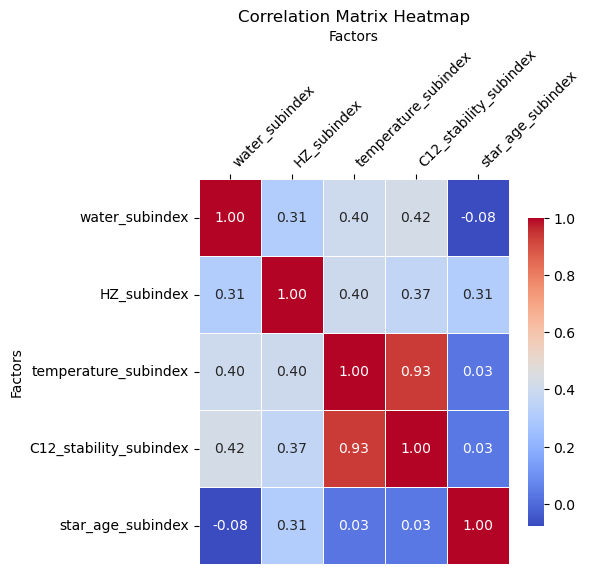

In [19]:
# CORRELATION ANALYSIS BETWEEN SUB-INDICES
selected_columns = ['water_subindex', 'HZ_subindex', 'temperature_subindex', 'C12_stability_subindex',  'star_age_subindex']
data_cor = data[selected_columns]

numeric_data_cor = data_cor.select_dtypes(include=[np.number])

correlation_matrix = numeric_data_cor.corr()

def calculate_p_value(r,n):
    df = n - 2
    t_squared = r**2 * (df/(1-r**2))
    p_value = betainc(0.5 * df, 0.5, df/(df + t_squared))
    return p_value


p_values = pd.DataFrame(np.zeros((numeric_data_cor.shape[1], numeric_data_cor.shape[1])), columns=numeric_data_cor.columns, index=numeric_data_cor.columns)

for col1 in numeric_data_cor.columns:
    for col2 in numeric_data_cor.columns:
        if col1 != col2:
            # Calculate Pearson correlation
            r = correlation_matrix.loc[col1, col2]
            # Number of observations
            n = numeric_data_cor.shape[0]
            # Calculate p-value
            p_val = calculate_p_value(r, n)
            p_values.loc[col1, col2] = p_val
        else:
            p_values.loc[col1, col2] = np.nan  # or 1, since a variable is perfectly correlated with itself


print(p_values)
plt.figure(figsize=(5, 5))  # Set the size of the plot
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar_kws={"shrink": .8})
heatmap.xaxis.set_ticks_position('top')
heatmap.xaxis.set_label_position('top')  # Move the x-axis label to the top
plt.xticks(rotation=45, ha='left') 

# Add title and labels
plt.title('Correlation Matrix Heatmap')
plt.xlabel('Factors')
plt.ylabel('Factors')

# Display the plot
plt.show()

In [20]:
# OBTAIN THE INTERACTION WEIGHTS FROM THE CORRELATION DATA
interaction_weights = []

for index, (column_name, column_data) in enumerate(correlation_matrix.items()):
    column_list = column_data.tolist()

    threshold = 0.75

    # filter the column
    column_filtered = [0 if abs(x) < threshold or abs(x) == 1 else x for x in column_list]

    # obtain the interaction weights
    non_zero_count = 0
    non_zero_sum = 0

    for value in column_filtered:
        if value != 0:
            non_zero_count += 1
            non_zero_sum += value

    interaction_weight = 1
    if (non_zero_count != 0):
        interaction_weight = non_zero_sum/non_zero_count

    interaction_weight_processed = 1
    match interaction_weight:
        case interaction_weight if 0.75 <= interaction_weight < 0.85:
            interaction_weight_processed = 0.95 # lose 5%
        case interaction_weight if 0.85 <= interaction_weight < 0.95:
            interaction_weight_processed = 0.90 # lose 10%
        case interaction_weight if 0.95 <= interaction_weight < 1:
            interaction_weight_processed = 0.85 # lose 15% 

    # record the interaction weight
    interaction_weights.append(interaction_weight_processed)

# display the interaction weights
print(f"Interaction Weights: {interaction_weights}")


Interaction Weights: [1, 1, 0.9, 0.9, 1]


## Section 4: HUI - PO-HUI with Interactions

In [21]:
# CALCULATE HUI
def hui(weights, interactions, *values):
    weights_with_interactions = [weight * interaction for weight, interaction in zip(weights, interactions)]
    weighted_values = [processed_weight * value for processed_weight, value in zip(weights_with_interactions, values)]
    result = sum(weighted_values)
    return result

weights_validated = [0.17103965, 0.19340681, 0.2592849, 0.25840178, 0.11786686]
interaction_weights_validated = [1, 1, 0.9, 0.9, 1]
data['HUI'] = data.apply(lambda row: hui(weights_validated, interaction_weights_validated, row['water_subindex'], row['HZ_subindex'], row['temperature_subindex'], row['C12_stability_subindex'], row['star_age_subindex']), axis = 1)

# DISPLAY HUI
def print_pretty(planet, hui, PO_HUI):
    print(f'Planet -> {planet}, HUI -> {hui}, PO_HUI -> {PO_HUI}')

for index, row in data.iterrows():
    print_pretty(row['planet'], row['HUI'], row['PO_HUI'])

Planet -> Mars, HUI -> 0.39925188150304486, PO_HUI -> 0.486577529688228
Planet -> Jupiter, HUI -> 0.16672532806790835, PO_HUI -> 0.24173667238395585
Planet -> Saturn, HUI -> 0.1609020246436776, PO_HUI -> 0.23657297100263547
Planet -> Uranus, HUI -> 0.15060477656069668, PO_HUI -> 0.22742511320493844
Planet -> Neptune, HUI -> 0.14984477761286918, PO_HUI -> 0.22674708575063668
Planet -> Earth, HUI -> 0.7649736112425265, PO_HUI -> 0.7979328055614352
Planet -> Mars_prehistoric, HUI -> 0.6362906802234733, PO_HUI -> 0.6293173913085917
Planet -> Earth_prehistoric, HUI -> 0.6075991563016476, PO_HUI -> 0.5968747769621318
Planet -> 1RXS 1609 b, HUI -> 0.06741390806754825, PO_HUI -> 0.07453986882214585
Planet -> 24 LMi b, HUI -> 0.12621625173345632, PO_HUI -> 0.12778098169175467
Planet -> 2MASS J1315-2649 b, HUI -> 0.1539164262716603, PO_HUI -> 0.21359839918078719
Planet -> 54 Psc c, HUI -> 0.07485950179433495, PO_HUI -> 0.08105826734778666
Planet -> AF Lep b, HUI -> 0.06848962854562962, PO_HUI ->

## Section 5: Saving Data

In [28]:
# SAVING DATA
data.to_csv('../Data/results.csv', index=False)

